In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from randomizedSVD import rsvd

In [17]:
def rank_k_rsvd_approximation_2(A, k, p = 5):
    U_k, S_k, Vt_k = rsvd(A, k, p)
    return U_k @ (S_k * Vt_k)


In [18]:
def rank_k_rsvd_approximation(A, k, p = 5):
    U_k, S_k, Vt_k = rsvd(A, k, p)
    Sigma_k = np.diag(S_k)
    return U_k @ Sigma_k @ Vt_k   # U_k @ (S_k * Vt_k)


def rank_k_svd_approximation(A, k):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    return U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]


def mse(original, approximation):
    return np.mean((original - approximation) ** 2)


def l2_error(A, B):
    _, S, _ = np.linalg.svd(A - B)
    return np.max(S)


def plot_greyscale_matrix(A):
    plt.figure(figsize=(5, 5))
    plt.imshow(A, cmap="gray")
    plt.axis('off')
    plt.show()


def plot_greyscale_comparison(A, B, C, k, t1=None, t2=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

    ax1.imshow(A, cmap="gray")
    ax2.imshow(B, cmap="gray")
    ax3.imshow(C, cmap="gray")

    ax1.set_title(f"Original image\nSize = {A.shape}")
    ax2.set_title(f"Rank {k} RSVD approximation\n t = {t1:.2f}s")
    ax3.set_title(f"Rank {k} SVD approximation\n t = {t2:.2f}s")

    ax1.axis("off")
    ax2.axis("off")
    ax3.axis("off")

    plt.tight_layout()
    plt.show()


$$
\mathbb{E}\|A - QQ^TA\| \le 
\left[
1 + \frac{4\sqrt{k+p}}{p-1}\sqrt{\min\{m,n\}}
\right]\sigma_{k+1}
$$

In [19]:
# Read in image and convert to greyscale matrix
img = Image.open("tree.jpg")
img_grey = img.convert("L")
A = np.array(img_grey)
A.shape

(600, 600)

In [20]:
def svd_error_comparison(A, min_k, max_k):
    error_true = np.zeros(max_k - min_k)
    error_expected = np.zeros(max_k - min_k)
    
    U, S, Vt = np.linalg.svd(A, full_matrices=False)

    for i, k in enumerate(range(min_k, max_k)):
        # Compute the k-rank approximation
        Ak = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]

        # Find the true error (spectral norm)
        ek_true = np.linalg.norm(A - Ak, 2)

        # Find the expected error
        ek_expected = S[k + 1]

        # Results
        error_true[i] = ek_true
        error_expected[i] = ek_expected
    
    return error_true, error_expected


def rsvd_error_comparison(A, min_k, max_k, p = 5):
    n = max_k - min_k
    error_true = np.zeros(n)
    error_expected_1 = np.zeros(n)
    error_expected_2 = np.zeros(n)
    
    m, n = A.shape
    _, S, _ = np.linalg.svd(A)

    alpha = 4 * np.sqrt(np.min((m, n))) / (p - 1)
    beta = 9 * np.sqrt(np.min((m, n)))

    for i, k in enumerate(range(min_k, max_k)):
        # Compute the k-rank approximation
        Uk, Sk, Vtk = rsvd(A, k, p)
        Ak = Uk @ np.diag(Sk) @ Vtk

        # Find the true error (spectral norm)
        error_true[i] = np.linalg.norm(A - Ak, 2)

        # Find the expected error
        error_expected_1[i] = (1 + alpha * np.sqrt(k + p)) * S[k + 1]
        error_expected_2[i] = (1 + beta * np.sqrt(k + p)) * S[k + 1]
    
    return error_true, error_expected_1, error_expected_2

In [21]:
min_k = 50
max_k = 100
p = 50
e_true_rsvd, e1_expected_rsvd, e2_expected_rsvd = rsvd_error_comparison(A, min_k, max_k, p)
e_true_svd, e_expected_svd = svd_error_comparison(A, min_k, max_k)

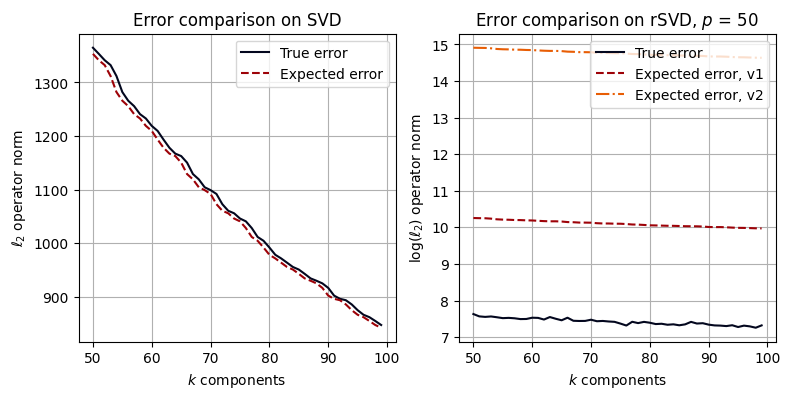

In [22]:
k_range = range(50, 100)
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax.plot(k_range, e_true_svd, label="True error", c='#03071E')
ax.plot(k_range, e_expected_svd, label="Expected error", c='#9D0208', ls='--')
ax.set_title("Error comparison on SVD")
ax.set_ylabel(r"$\ell_2$ operator norm")
ax.set_xlabel(r"$k$ components")

ax2.plot(k_range, np.log(e_true_rsvd), label="True error", c='#03071E')
ax2.plot(k_range, np.log(e1_expected_rsvd), label="Expected error, v1", c='#9D0208', ls='--')
ax2.plot(k_range, np.log(e2_expected_rsvd), label="Expected error, v2", c='#E85D04', ls='-.')
ax2.set_title(f"Error comparison on rSVD, $p$ = {p}")
ax2.set_ylabel(r"$\log(\ell_2)$ operator norm")
ax2.set_xlabel(r"$k$ components")

ax.grid(True)
ax2.grid(True)
ax.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.show()

$$
\mathbb{E}\|A - QQ^TA\| \le 
\left[
1 + \frac{4\sqrt{k+p}}{p-1}\sqrt{\min\{m,n\}}
\right]\sigma_{k+1}
$$

In [60]:
def gamma(m, n, k, p):
    return 1 + 4 * np.sqrt(k + p) / (p - 1) * np.sqrt(min(m, n))

k_space = [25, 50, 75, 100]
p_space = range(5, 100)
m, n = A.shape

gammas = [[gamma(m, n, k, p) for p in p_space] for k in k_space]

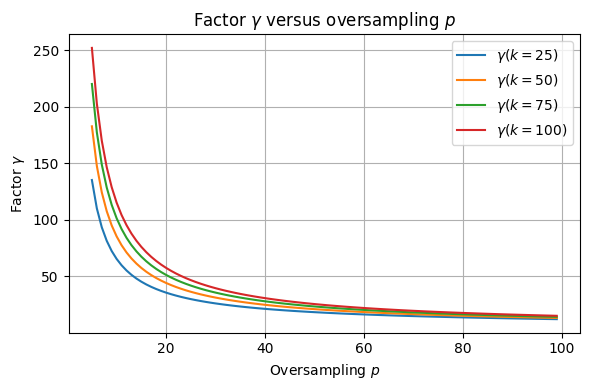

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i, k in enumerate(k_space):
    ax.plot(p_space, gammas[i], label=f"$\\gamma(k={k})$")

ax.set_title("Factor $\\gamma$ versus oversampling $p$")
ax.set_xlabel("Oversampling $p$")
ax.set_ylabel("Factor $\\gamma$")
ax.grid(True)
ax.legend()
fig.tight_layout()

In [25]:
def comparison_pipeline(A, k):
    # Find k-rank approximation using RSVD
    t0 = time()
    A_k = rank_k_rsvd_approximation(A, k)
    dt1 = time() - t0

    # Find k-rank approximation using SVD
    t0 = time()
    A_k_svd = rank_k_svd_approximation(A, k)
    dt2 = time() - t0

    # Compare the images
    plot_greyscale_comparison(A, A_k, A_k_svd, k, dt1, dt2)

In [26]:
def mse_and_time_algorithm(A, k, algorithm):
    # Time the algorithm 
    t0 = time()
    A_k = algorithm(A, k)
    dt = time() - t0

    # Compute the MSE
    mse_k = mse(A, A_k)
    return mse_k, dt





k_range = range(10, 250)

SVD_MSE = []
RSVD_MSE = []
SVD_time = []
RSVD_time = []

# rank k SVD
for k in k_range:
    mse_k, dt_k = mse_and_time_algorithm(A, k, rank_k_svd_approximation)
    SVD_MSE.append(mse_k)
    SVD_time.append(dt_k)

# rank k RSVD
for k in k_range:
    mse_k, dt_k = mse_and_time_algorithm(A, k, rank_k_rsvd_approximation)
    RSVD_MSE.append(mse_k)
    RSVD_time.append(dt_k)



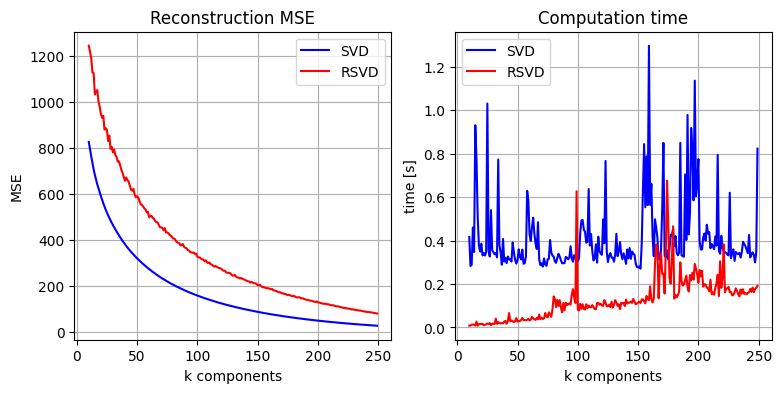

In [27]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax.plot(k_range, SVD_MSE, label="SVD", c='b')
ax.plot(k_range, RSVD_MSE, label="RSVD", c='r')
ax.set_title("Reconstruction MSE")
ax.set_ylabel("MSE")
ax.set_xlabel("k components")

ax2.plot(k_range, SVD_time, label="SVD", c='b')
ax2.plot(k_range, RSVD_time, label="RSVD", c='r')
ax2.set_title("Computation time")
ax2.set_ylabel("time [s]")
ax2.set_xlabel("k components")

ax.grid(True)
ax2.grid(True)
ax.legend()
ax2.legend()
plt.savefig("../figures/SVD_vs_rSVD.jpg")
plt.show()

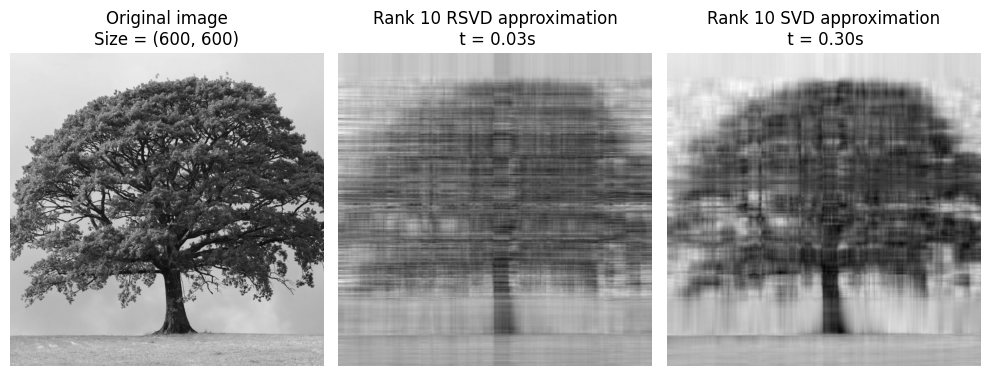

In [28]:
comparison_pipeline(A, 10)